In [1]:
import pandas as pd
import numpy as np

## Load the data

Dataset; https://archive.ics.uci.edu/ml/datasets/Ozone%20Level%20Detection

In [2]:
# Only difference between 1hr and 8hr level detection is the label
# => we opt for the 8hr data set

url_8hr_data = "https://archive.ics.uci.edu/ml/machine-learning-databases/ozone/eighthr.data"
url_8hr_cols = "https://archive.ics.uci.edu/ml/machine-learning-databases/ozone/eighthr.names"

get_col = lambda c: c.split(":")[0].strip()
cols_8hr = pd.read_csv(url_8hr_cols)["1"].apply(get_col).values

df_8hr = pd.read_csv(
    url_8hr_data, 
    header=None, 
    names=list(cols_8hr) + ["label"], 
    na_values="?",
    parse_dates=["Date"],
    index_col="Date",
    dtype="float32"
,)
df_8hr["label"] = df_8hr["label"].astype(np.int8)
df_8hr

,WSR0,WSR1,WSR2,WSR3,WSR4,WSR5,WSR6,WSR7,WSR8,WSR9,...,RH50,U50,V50,HT50,KI,TT,SLP,SLP_,Precp,label
Date,,,,,,,,,,,,,,,,,,,,,
1998-01-01,0.8,1.8,2.4,2.1,2.0,2.1,1.5,1.7,1.9,2.3,...,0.15,10.67,-1.56,5795.0,-12.10,17.900000,10330.0,-55.0,0.00,0
1998-01-02,2.8,3.2,3.3,2.7,3.3,3.2,2.9,2.8,3.1,3.4,...,0.48,8.39,3.84,5805.0,14.05,29.000000,10275.0,-55.0,0.00,0
1998-01-03,2.9,2.8,2.6,2.1,2.2,2.5,2.5,2.7,2.2,2.5,...,0.60,6.94,9.80,5790.0,17.90,41.299999,10235.0,-40.0,0.00,0
1998-01-04,4.7,3.8,3.7,3.8,2.9,3.1,2.8,2.5,2.4,3.1,...,0.49,8.73,10.54,5775.0,31.15,51.700001,10195.0,-40.0,2.08,0
1998-01-05,2.6,2.1,1.6,1.4,0.9,1.5,1.2,1.4,1.3,1.4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.58,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2004-12-27,0.3,0.4,0.5,0.5,0.2,0.3,0.4,0.4,1.3,2.2,...,0.07,7.93,-4.41,5800.0,-25.60,21.799999,10295.0,65.0,0.00,0
2004-12-28,1.0,1.4,1.1,1.7,1.5,1.7,1.8,1.5,2.1,2.4,...,0.04,5.95,-1.14,5845.0,-19.40,19.100000,10310.0,15.0,0.00,0
2004-12-29,0.8,0.8,1.2,0.9,0.4,0.6,0.8,1.1,1.5,1.5,...,0.06,7.80,-0.64,5845.0,-9.60,35.200001,10275.0,-35.0,0.00,0


In [3]:
diffs = df_8hr.index[1:].values - df_8hr.index[:-1].values
print(max(diffs) / np.timedelta64(1, 'D'), min(diffs) / np.timedelta64(1, 'D'))

6.0 1.0


=> There are gaps in the data (with a max of 6 days)

In [4]:
df_8hr.columns

Index(['WSR0', 'WSR1', 'WSR2', 'WSR3', 'WSR4', 'WSR5', 'WSR6', 'WSR7', 'WSR8',
       'WSR9', 'WSR10', 'WSR11', 'WSR12', 'WSR13', 'WSR14', 'WSR15', 'WSR16',
       'WSR17', 'WSR18', 'WSR19', 'WSR20', 'WSR21', 'WSR22', 'WSR23', 'WSR_PK',
       'WSR_AV', 'T0', 'T1', 'T2', 'T3', 'T4', 'T5', 'T6', 'T7', 'T8', 'T9',
       'T10', 'T11', 'T12', 'T13', 'T14', 'T15', 'T16', 'T17', 'T18', 'T19',
       'T20', 'T21', 'T22', 'T23', 'T_PK', 'T_AV', 'T85', 'RH85', 'U85', 'V85',
       'HT85', 'T70', 'RH70', 'U70', 'V70', 'HT70', 'T50', 'RH50', 'U50',
       'V50', 'HT50', 'KI', 'TT', 'SLP', 'SLP_', 'Precp', 'label'],
      dtype='object')

**note**:
* **hourly features**
    * `WSR<0-23>`: wind speed data, numb indicates the hour of that day
    * `T<0-23>`: temperature data, numb indicates the hour of that day

* **daily features**:
    * `WSR_PK`: Peak wind speed of that day
    * `WSR_AV`: Average wind speed of that day
    * `T_PK`: Peak Temperature of that day
    * `T_AV`: Average Temperature of that day
    * `KI`: K-index - measure of thunderstorm potential based on vertical temperature lapse rate, see [here](https://w1.weather.gov/glossary/index.php?letter=k)
    * `TT `: T-Totals - index used to assess storm strength, see [here](http://www.theweatherprediction.com/habyhints/302/)
    * `SLP`, `SLP_`: Sea level pressure, `_` indicates pressure from the previous day.
    * `V<50-85`: V-wind - N-S direction wind at 500, 700, 850 hpa level
    * `U<50-85`: U-wind - E-W direction wind at 500, 700, 850 hpa level
    * `HT<50-85>`: Geopotential height at 500, 700, 850 hpa

### Create a hourly dataframe with the wind speed and temperature

In [5]:
# Create a hourly dataframe (withholds only WSR and T features)
df_daily = pd.DataFrame(index=df_8hr.index)
dfs = [df_daily]
for hour in range(1, 24):
    dfs += [pd.DataFrame(index=pd.to_datetime(df_daily.index + np.timedelta64(hour, "h")))]
df_hourly = pd.concat(dfs).sort_index()

# Add the hourly wind speed values
wsr_cols = [f"WSR{h}" for h in range(24)]
df_hourly["WSR"] = np.hstack(df_8hr[wsr_cols].values)
# Add the hourly temperature values
t_cols = [f"T{h}" for h in range(24)]
df_hourly["T"] = np.hstack(df_8hr[t_cols].values)

df_hourly

,WSR,T
Date,,
1998-01-01 00:00:00,0.8,5.200000
1998-01-01 01:00:00,1.8,6.100000
1998-01-01 02:00:00,2.4,6.100000
1998-01-01 03:00:00,2.1,6.100000
1998-01-01 04:00:00,2.0,6.100000
...,...,...
2004-12-31 19:00:00,2.1,20.200001
2004-12-31 20:00:00,3.2,20.900000
2004-12-31 21:00:00,2.8,21.200001


### Create a daily dataframe with the other features (and the label)

In [6]:
df_daily = df_8hr.drop(columns=wsr_cols + t_cols)
df_daily

,WSR_PK,WSR_AV,T_PK,T_AV,T85,RH85,U85,V85,HT85,T70,...,RH50,U50,V50,HT50,KI,TT,SLP,SLP_,Precp,label
Date,,,,,,,,,,,,,,,,,,,,,
1998-01-01,5.5,3.1,19.100000,12.500000,6.7,0.11,3.83,0.14,1612.0,-2.3,...,0.15,10.67,-1.56,5795.0,-12.10,17.900000,10330.0,-55.0,0.00,0
1998-01-02,5.5,3.4,22.400000,17.799999,9.0,0.25,-0.41,9.53,1594.5,-2.2,...,0.48,8.39,3.84,5805.0,14.05,29.000000,10275.0,-55.0,0.00,0
1998-01-03,5.6,3.5,22.200001,18.700001,9.0,0.56,0.89,10.17,1568.5,0.9,...,0.60,6.94,9.80,5790.0,17.90,41.299999,10235.0,-40.0,0.00,0
1998-01-04,4.7,3.2,19.600000,18.700001,9.9,0.89,-0.34,8.58,1546.5,3.0,...,0.49,8.73,10.54,5775.0,31.15,51.700001,10195.0,-40.0,2.08,0
1998-01-05,3.7,2.3,26.000000,21.100000,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.58,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2004-12-27,3.9,1.6,14.800000,7.700000,5.5,0.33,-2.25,-1.92,1576.0,3.2,...,0.07,7.93,-4.41,5800.0,-25.60,21.799999,10295.0,65.0,0.00,0
2004-12-28,5.0,2.6,18.400000,12.900000,5.8,0.27,-2.45,4.71,1600.5,3.4,...,0.04,5.95,-1.14,5845.0,-19.40,19.100000,10310.0,15.0,0.00,0
2004-12-29,3.9,1.9,20.600000,17.700001,7.5,0.79,7.57,3.13,1591.0,4.6,...,0.06,7.80,-0.64,5845.0,-9.60,35.200001,10275.0,-35.0,0.00,0


# EDA

Some very basic Explorative Data Analysis (EDA)

## Look at `label`

In [7]:
df_8hr["label"].value_counts()

0    2374
1     160
Name: label, dtype: int64

=> There is a clear class imbalance!

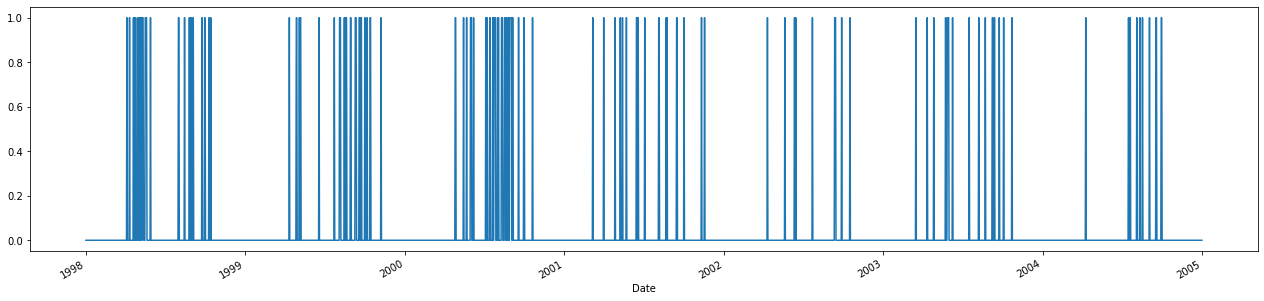

In [8]:
df_8hr["label"].plot(figsize=(22,5))

=> We observe clearly a temporal correlation in the labels (they tend to occur in batches)

Consequences;
* Temporal train-test split is necessary (no shuffling)!
* Temporal K-fold grid search is necessary (no shuffling)!

Idea;  
Label is on daily level and has a clear temporal correlation => use multi-day historical temporal information.

## Quick look at the daily data

In [9]:
df_daily.columns

Index(['WSR_PK', 'WSR_AV', 'T_PK', 'T_AV', 'T85', 'RH85', 'U85', 'V85', 'HT85',
       'T70', 'RH70', 'U70', 'V70', 'HT70', 'T50', 'RH50', 'U50', 'V50',
       'HT50', 'KI', 'TT', 'SLP', 'SLP_', 'Precp', 'label'],
      dtype='object')

In [10]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

fig = make_subplots(rows=2, cols=1, shared_xaxes=True, subplot_titles=["Daily Data", "Label"])

nb_days = 500

for col in df_daily.columns:
    row_nb = 2 if col == "label" else 1
    fig.add_trace(
        go.Scattergl(
            x=df_daily[:nb_days].index, y=df_daily[col][:nb_days], name=col
        ), row=row_nb, col=1,
    )

fig.show()#renderer="png")

# ML time

In [11]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import classification_report

### train - test split

In [12]:
# The percentage of data used for testing
test_pct = 0.2

# The temporal margin in days between train and test set  (prevent data leakage)
day_margin = 20

# Temporal split: Use the last test_pct of the data as test_data
train_idx = df_daily.index[:-int(len(df_daily)*test_pct)]
test_idx = df_daily.index[-int(len(df_daily)*test_pct) + day_margin:]

print(len(train_idx), len(test_idx))

2028 486


## Modelling - Baseline = only use daily data

In [13]:
X_train, y_train = df_8hr.drop(columns="label").loc[train_idx], df_8hr["label"].loc[train_idx]
X_test, y_test = df_8hr.drop(columns="label").loc[test_idx], df_8hr["label"].loc[test_idx]

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(2028, 72) (2028,)
(486, 72) (486,)


### Logistic regression

In [14]:
pipe = Pipeline(
    [
        ("impute", SimpleImputer(strategy="median")),
        ("scale", StandardScaler()),
        ("lr", LogisticRegression(class_weight="balanced", penalty="l1", solver="liblinear", random_state=42)),
    ]
)

pipe.fit(X_train, y_train)

Pipeline(steps=[('impute', SimpleImputer(strategy='median')),
                ('scale', StandardScaler()),
                ('lr',
                 LogisticRegression(class_weight='balanced', penalty='l1',
                                    random_state=42, solver='liblinear'))])

In [15]:
pipe.score(X_test, y_test)

0.8559670781893004

In [16]:
print(classification_report(y_test, pipe.predict(X_test)))

              precision    recall  f1-score   support

           0       0.99      0.86      0.92       469
           1       0.17      0.82      0.29        17

    accuracy                           0.86       486
   macro avg       0.58      0.84      0.60       486
weighted avg       0.96      0.86      0.90       486



### Random forest classifier

In [17]:
pipe = Pipeline(
    [
        ("impute", SimpleImputer(strategy="median")),
        ("scale", StandardScaler()),
        ("rf", RandomForestClassifier(class_weight="balanced", random_state=42, max_depth=5)),
    ]
)

pipe.fit(X_train, y_train)

Pipeline(steps=[('impute', SimpleImputer(strategy='median')),
                ('scale', StandardScaler()),
                ('rf',
                 RandomForestClassifier(class_weight='balanced', max_depth=5,
                                        random_state=42))])

In [18]:
pipe.score(X_test, y_test)

0.8518518518518519

In [19]:
print(classification_report(y_test, pipe.predict(X_test)))

              precision    recall  f1-score   support

           0       1.00      0.85      0.92       469
           1       0.18      0.94      0.31        17

    accuracy                           0.85       486
   macro avg       0.59      0.89      0.61       486
weighted avg       0.97      0.85      0.90       486



## Feature extraction with tsflex

In [20]:
from tsflex.features import MultipleFeatureDescriptors, FeatureCollection
from tsflex.features.integrations import make_robust
import scipy.stats as ss

In [21]:
def slope(x): return (x[-1] - x[0]) / x[0] if x[0] else 0
def abs_diff_mean(x): return np.mean(np.abs(x[1:] - x[:-1])) if len(x) > 1 else 0
def diff_std(x): return np.std(x[1:] - x[:-1]) if len(x) > 1 else 0

funcs = [make_robust(f) for f in [np.min, np.max, np.std, np.mean, slope, ss.skew, abs_diff_mean, diff_std, sum, len]]

hourly_data_feats = MultipleFeatureDescriptors(
    functions=funcs,
    series_names=["WSR", "T"],
    windows=["1D", "3D", "5D"],
    strides="1D"    
)
         
daily_data_feats = MultipleFeatureDescriptors(
    functions=funcs,
    series_names=[c for c in df_daily.columns if c != "label"],
    windows=["3D", "5D", "14D", "30D"],
    strides="1D"    
)

# Create the feature collection
fc = FeatureCollection(
    feature_descriptors=[hourly_data_feats, daily_data_feats]
)
fc

HT50: (
	win: 3D    , stride: 1D: [
		FeatureDescriptor - func: FuncWrapper([robust]__amin, ['amin'], {}),
		FeatureDescriptor - func: FuncWrapper([robust]__amax, ['amax'], {}),
		FeatureDescriptor - func: FuncWrapper([robust]__std, ['std'], {}),
		FeatureDescriptor - func: FuncWrapper([robust]__mean, ['mean'], {}),
		FeatureDescriptor - func: FuncWrapper([robust]__slope, ['slope'], {}),
		FeatureDescriptor - func: FuncWrapper([robust]__skew, ['skew'], {}),
		FeatureDescriptor - func: FuncWrapper([robust]__abs_diff_mean, ['abs_diff_mean'], {}),
		FeatureDescriptor - func: FuncWrapper([robust]__diff_std, ['diff_std'], {}),
		FeatureDescriptor - func: FuncWrapper([robust]__sum, ['sum'], {}),
		FeatureDescriptor - func: FuncWrapper([robust]__len, ['len'], {}),
	]
	win: 5D    , stride: 1D: [
		FeatureDescriptor - func: FuncWrapper([robust]__amin, ['amin'], {}),
		FeatureDescriptor - func: FuncWrapper([robust]__amax, ['amax'], {}),
		FeatureDescriptor - func: FuncWrapper([robust]__std, ['st

In [22]:
%%time
# Calculate the features
df_feats = fc.calculate(data=[df_daily, df_hourly], window_idx="end", approve_sparsity=True, return_df=True, show_progress=True)
df_feats

100%|██████████| 1020/1020 [00:21<00:00, 48.16it/s]


CPU times: user 2.92 s, sys: 293 ms, total: 3.22 s
Wall time: 22 s


,WSR__amin__w=1D_s=1D,WSR__amax__w=1D_s=1D,WSR__slope__w=1D_s=1D,WSR__len__w=1D_s=1D,WSR__sum__w=1D_s=1D,WSR__amin__w=3D_s=1D,WSR__amax__w=3D_s=1D,WSR__mean__w=1D_s=1D,WSR__slope__w=3D_s=1D,WSR__abs_diff_mean__w=1D_s=1D,...,Precp__abs_diff_mean__w=30D_s=1D,Precp__std__w=30D_s=1D,Precp__len__w=30D_s=1D,Precp__diff_std__w=30D_s=1D,Precp__sum__w=30D_s=1D,SLP___skew__w=30D_s=1D,Precp__skew__w=3D_s=1D,Precp__skew__w=5D_s=1D,Precp__skew__w=14D_s=1D,Precp__skew__w=30D_s=1D
Date,,,,,,,,,,,,,,,,,,,,,
1998-01-02,0.8,5.5,2.250000,24.0,74.400000,NaN,NaN,3.100000,NaN,0.469565,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1998-01-03,2.2,5.5,0.000000,24.0,81.000000,NaN,NaN,3.375000,NaN,0.434783,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1998-01-04,2.1,5.6,0.586207,24.0,83.400000,0.8,5.6,3.475000,4.750000,0.439130,...,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,NaN
1998-01-05,1.9,4.7,-0.085106,24.0,76.700000,1.9,5.6,3.195833,0.535714,0.513043,...,NaN,NaN,NaN,NaN,NaN,NaN,0.707107,NaN,NaN,NaN
1998-01-06,0.9,3.7,0.307692,24.0,54.800000,0.9,5.6,2.283333,0.172414,0.373913,...,NaN,NaN,NaN,NaN,NaN,NaN,0.482027,1.244689,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2004-12-27,0.2,2.1,-0.555556,24.0,18.000000,0.1,4.5,0.750000,-0.888889,0.221739,...,0.344828,0.499933,30.0,0.745057,5.68,0.727401,0.707107,1.452451,2.028940,3.507514
2004-12-28,0.2,3.9,2.666667,24.0,39.700000,0.1,3.9,1.654167,-0.521739,0.304348,...,0.344828,0.499933,30.0,0.745057,5.68,0.746427,0.000000,1.500000,2.028940,3.507514
2004-12-29,1.0,5.0,0.100000,24.0,63.399999,0.2,5.0,2.641667,0.222222,0.482609,...,0.337931,0.499933,30.0,0.744099,5.68,0.851970,0.000000,1.500000,2.028939,3.507514


In [23]:
# Merge the features with the original dataframe (and the labels)
df_merged = df_feats.join(df_8hr)
df_merged

,WSR__amin__w=1D_s=1D,WSR__amax__w=1D_s=1D,WSR__slope__w=1D_s=1D,WSR__len__w=1D_s=1D,WSR__sum__w=1D_s=1D,WSR__amin__w=3D_s=1D,WSR__amax__w=3D_s=1D,WSR__mean__w=1D_s=1D,WSR__slope__w=3D_s=1D,WSR__abs_diff_mean__w=1D_s=1D,...,RH50,U50,V50,HT50,KI,TT,SLP,SLP_,Precp,label
Date,,,,,,,,,,,,,,,,,,,,,
1998-01-02,0.8,5.5,2.250000,24.0,74.400000,NaN,NaN,3.100000,NaN,0.469565,...,0.48,8.39,3.84,5805.0,14.050000,29.000000,10275.0,-55.0,0.00,0.0
1998-01-03,2.2,5.5,0.000000,24.0,81.000000,NaN,NaN,3.375000,NaN,0.434783,...,0.60,6.94,9.80,5790.0,17.900000,41.299999,10235.0,-40.0,0.00,0.0
1998-01-04,2.1,5.6,0.586207,24.0,83.400000,0.8,5.6,3.475000,4.750000,0.439130,...,0.49,8.73,10.54,5775.0,31.150000,51.700001,10195.0,-40.0,2.08,0.0
1998-01-05,1.9,4.7,-0.085106,24.0,76.700000,1.9,5.6,3.195833,0.535714,0.513043,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.58,0.0
1998-01-06,0.9,3.7,0.307692,24.0,54.800000,0.9,5.6,2.283333,0.172414,0.373913,...,0.09,11.98,11.28,5770.0,27.950001,46.250000,10120.0,NaN,5.84,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2004-12-27,0.2,2.1,-0.555556,24.0,18.000000,0.1,4.5,0.750000,-0.888889,0.221739,...,0.07,7.93,-4.41,5800.0,-25.600000,21.799999,10295.0,65.0,0.00,0.0
2004-12-28,0.2,3.9,2.666667,24.0,39.700000,0.1,3.9,1.654167,-0.521739,0.304348,...,0.04,5.95,-1.14,5845.0,-19.400000,19.100000,10310.0,15.0,0.00,0.0
2004-12-29,1.0,5.0,0.100000,24.0,63.399999,0.2,5.0,2.641667,0.222222,0.482609,...,0.06,7.80,-0.64,5845.0,-9.600000,35.200001,10275.0,-35.0,0.00,0.0


In [24]:
X_train, y_train = df_merged.drop(columns="label").loc[train_idx[5:]], df_merged["label"].loc[train_idx[5:]]
X_test, y_test = df_merged.drop(columns="label").loc[test_idx], df_merged["label"].loc[test_idx]

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(2023, 1092) (2023,)
(486, 1092) (486,)


## Modelling with tsflex features

#### Feature selection

In [25]:
from sklearn.feature_selection import RFECV
from sklearn.model_selection import KFold

lr = LogisticRegression(class_weight="balanced", solver="liblinear", random_state=42)

# Only 4-fold CV in order to reduce temporal data leakage
kfold = KFold(n_splits=4, shuffle=False)
rfecv = RFECV(estimator=lr, step=20, cv=kfold,
              scoring='f1_macro', n_jobs=4,
)

t_pipe = Pipeline(
    [
        ("impute", SimpleImputer(strategy="median")),
        ("scale", StandardScaler()),
    ]
)

rfecv.fit(t_pipe.fit_transform(X_train), y_train)

RFECV(cv=KFold(n_splits=4, random_state=None, shuffle=False),
      estimator=LogisticRegression(class_weight='balanced', random_state=42,
                                   solver='liblinear'),
      n_jobs=4, scoring='f1_macro', step=20)

In [26]:
selected_cols = X_train.columns[rfecv.support_].values
print(len(selected_cols))
selected_cols

52


array(['WSR__mean__w=5D_s=1D', 'T__diff_std__w=1D_s=1D',
       'T__abs_diff_mean__w=5D_s=1D', 'WSR_PK__slope__w=30D_s=1D',
       'WSR_AV__amax__w=14D_s=1D', 'T_PK__amax__w=3D_s=1D',
       'T_PK__sum__w=14D_s=1D', 'T_PK__amax__w=30D_s=1D',
       'T_AV__abs_diff_mean__w=3D_s=1D',
       'T_AV__abs_diff_mean__w=14D_s=1D', 'T85__amax__w=14D_s=1D',
       'RH85__diff_std__w=3D_s=1D', 'RH85__amin__w=14D_s=1D',
       'V85__mean__w=3D_s=1D', 'V85__abs_diff_mean__w=3D_s=1D',
       'V85__amin__w=14D_s=1D', 'V85__diff_std__w=14D_s=1D',
       'T70__abs_diff_mean__w=3D_s=1D', 'T70__mean__w=14D_s=1D',
       'U70__diff_std__w=14D_s=1D', 'V70__amin__w=14D_s=1D',
       'V70__abs_diff_mean__w=14D_s=1D', 'T50__abs_diff_mean__w=14D_s=1D',
       'T50__abs_diff_mean__w=30D_s=1D', 'RH50__sum__w=3D_s=1D',
       'RH50__amin__w=14D_s=1D', 'V50__amax__w=5D_s=1D',
       'V50__mean__w=5D_s=1D', 'V50__std__w=14D_s=1D',
       'V50__diff_std__w=14D_s=1D', 'HT50__diff_std__w=5D_s=1D',
       'HT50__abs_di

### Logistic regression

In [27]:
pipe = Pipeline(
    [
        ("impute", SimpleImputer(strategy="median")),
        ("scale", StandardScaler()),
        ("lr", LogisticRegression(class_weight="balanced", penalty="l2", solver="liblinear", random_state=42)),
    ]
)

pipe.fit(X_train[selected_cols], y_train)

Pipeline(steps=[('impute', SimpleImputer(strategy='median')),
                ('scale', StandardScaler()),
                ('lr',
                 LogisticRegression(class_weight='balanced', random_state=42,
                                    solver='liblinear'))])

In [28]:
pipe.score(X_test[selected_cols], y_test)

0.9156378600823045

In [29]:
print(classification_report(y_test, pipe.predict(X_test[selected_cols])))

              precision    recall  f1-score   support

         0.0       0.99      0.92      0.95       469
         1.0       0.25      0.71      0.37        17

    accuracy                           0.92       486
   macro avg       0.62      0.81      0.66       486
weighted avg       0.96      0.92      0.93       486



### Random forest classifier

In [30]:
pipe = Pipeline(
    [
        ("impute", SimpleImputer(strategy="median")),
        ("scale", StandardScaler()),
        ("rf", RandomForestClassifier(class_weight="balanced", random_state=42, max_depth=5)),
    ]
)

pipe.fit(X_train[selected_cols], y_train)

Pipeline(steps=[('impute', SimpleImputer(strategy='median')),
                ('scale', StandardScaler()),
                ('rf',
                 RandomForestClassifier(class_weight='balanced', max_depth=5,
                                        random_state=42))])

In [31]:
pipe.score(X_test[selected_cols], y_test)

0.8868312757201646

In [32]:
print(classification_report(y_test, pipe.predict(X_test[selected_cols])))

              precision    recall  f1-score   support

         0.0       0.99      0.89      0.94       469
         1.0       0.21      0.82      0.34        17

    accuracy                           0.89       486
   macro avg       0.60      0.86      0.64       486
weighted avg       0.97      0.89      0.92       486



# Final remarks

The results in this notebook indicate that using tsflex to extract (historical) features of the [ozone-level dataset](https://archive.ics.uci.edu/ml/datasets/Ozone%20Level%20Detection) yield an absolute performance gain of 6% in macro F1 (from 0.60 to 0.66). 

---

> *Note that this notebook is by far a finished ML project. Several important steps are missing such as;*
> * elaborate EDA of the raw data
> * elaborate EDA of the extracted features (more meaningful feature construction)
> * hyperparameter optimization of the models
> * learning curve analysis, rfpimp analysis, prediction analysis, ...